# 05 — SFT from Scratch: Turn a Base Model into a Chatbot

A pre-trained language model is just an **autocomplete engine**. It predicts the next token based on what came before. Ask it a question and it'll just... continue the text as if it's Shakespeare.

**Supervised Fine-Tuning (SFT)** teaches the model a new behavior: given an instruction, produce a helpful response. It does this by training on (instruction, response) pairs with a special twist — we only compute loss on the **assistant's response**, not the user's instruction.

In this notebook we'll:
1. Pre-train our Shakespeare GPT (base model = autocomplete)
2. Add **chat template tokens** (`<|user|>`, `<|assistant|>`, `<|end|>`)
3. Create a small conversation dataset
4. Implement SFT with **loss masking** — the key ingredient
5. See the model shift from autocomplete → instruction-following

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')
torch.manual_seed(1337)

Using device: cpu


## Part 1: Pre-train the Base Model

Same architecture from notebook 04 — a decoder-only transformer trained on Shakespeare. This gives us a model that can generate Shakespeare-like text, but has no concept of "instructions" or "responses".

In [2]:
# Load Shakespeare data and build character vocabulary
with open('../data/shakespeare/input.txt', 'r') as f:
    text = f.read()

chars = sorted(list(set(text)))
base_vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f'Vocab: {base_vocab_size} chars | Train: {len(train_data):,} | Val: {len(val_data):,}')

Vocab: 65 chars | Train: 1,003,854 | Val: 111,540


In [3]:
# Hyperparameters
batch_size = 32
block_size = 64
max_iters = 3000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2

def get_batch(split):
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [4]:
# Model architecture (same as notebook 04)

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            return logits, None
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = GPT(base_vocab_size).to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 211,777


In [5]:
# Pre-train on Shakespeare
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"step {iter}: train {losses['train']:.4f}, val {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

losses = estimate_loss(model)
print(f"\nFinal: train {losses['train']:.4f}, val {losses['val']:.4f}")

step 0: train 4.3387, val 4.3485
step 500: train 2.5164, val 2.5160
step 1000: train 2.3913, val 2.3980
step 1500: train 2.2969, val 2.3133
step 2000: train 2.2128, val 2.2304
step 2500: train 2.1494, val 2.1711

Final: train 2.0887, val 2.1244


In [6]:
# The base model is just autocomplete — it continues text
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print("=== Base model: just autocomplete ===")
print(decode(model.generate(context, max_new_tokens=200)[0].tolist()))

=== Base model: just autocomplete ===


AWMOUUTES:'dars do thre it gone stherses!

AUCYOLIY:
Foroth don! your liet.

YCIUO:
My VIseeat ort ven gebe and

LA Ca felees, abestunt yay thy cour your sied
Whellownce ter faill Antisbun to vy,
As 


In [7]:
# What happens if we try to "ask it a question"?
# We encode a question as Shakespeare characters and let it continue
question = "What is love?"
question_tokens = torch.tensor([encode(question)], dtype=torch.long, device=device)
print(f"Prompt: '{question}'")
print(f"Model continues with:")
output = model.generate(question_tokens, max_new_tokens=150)[0].tolist()
print(decode(output))
print()
print("^ It doesn't ANSWER the question — it just continues the text.")
print("  It has no concept of 'user asks, assistant responds'.")
print("  That's what SFT will teach it.")

Prompt: 'What is love?'
Model continues with:
What is love?

KICHARUS:
I tiny our ymy sumood veng emint I thoms kisy,d anses wo:
Whelt:
Ror:?
St I Na it I the buch thing sepony ury.

Go SING waty thet to you s

^ It doesn't ANSWER the question — it just continues the text.
  It has no concept of 'user asks, assistant responds'.
  That's what SFT will teach it.


## Part 2: What is SFT?

The base model learned **language** (which characters follow which) but not **behavior** (how to respond to instructions).

SFT teaches behavior by fine-tuning on structured conversations:

```
<|user|>Write a greeting<|end|><|assistant|>Good morrow, friend!<|end|>
```

Three key ingredients make this work:

### 1. Chat Template Tokens
Special tokens (`<|user|>`, `<|assistant|>`, `<|end|>`) that the model has **never seen during pre-training**. They create clear boundaries between roles. This is exactly how ChatGPT, Llama, etc. work — each model family has its own chat template.

### 2. Loss Masking
The critical insight: **we only compute loss on the assistant's response tokens**, not on the user's instruction. Why?
- The model shouldn't learn to *generate* user messages — it should learn to *respond* to them
- The user tokens provide context, but the gradient only flows through the assistant's words
- This is like a student reading a question (no grade) then writing an answer (graded)

### 3. The Format Itself
By seeing hundreds of (instruction → response) examples, the model learns: when you see `<|assistant|>`, switch from reading to responding. The special tokens become triggers for a new behavior mode.

In [8]:
# Step 1: Add special tokens to vocabulary
#
# Real tokenizers (tiktoken, sentencepiece) handle this with special token
# registries. We'll do the same thing manually for our character-level model.
#
# New token IDs are added AFTER the existing vocabulary:
#   0-64:  original Shakespeare characters
#   65:    <|user|>
#   66:    <|assistant|>
#   67:    <|end|>

SPECIAL_TOKENS = {
    '<|user|>': base_vocab_size,          # 65
    '<|assistant|>': base_vocab_size + 1,  # 66
    '<|end|>': base_vocab_size + 2,        # 67
}
ID_TO_SPECIAL = {v: k for k, v in SPECIAL_TOKENS.items()}
sft_vocab_size = base_vocab_size + len(SPECIAL_TOKENS)  # 68

def encode_sft(text):
    """Encode text, recognizing special tokens as single token IDs."""
    tokens = []
    i = 0
    while i < len(text):
        matched = False
        for token_str, token_id in SPECIAL_TOKENS.items():
            if text[i:].startswith(token_str):
                tokens.append(token_id)
                i += len(token_str)
                matched = True
                break
        if not matched:
            tokens.append(stoi[text[i]])
            i += 1
    return tokens

def decode_sft(tokens):
    """Decode token IDs back to text, handling special tokens."""
    result = []
    for t in tokens:
        if t in ID_TO_SPECIAL:
            result.append(ID_TO_SPECIAL[t])
        else:
            result.append(itos[t])
    return ''.join(result)

# Verify it works
test = "<|user|>Hello<|end|><|assistant|>Hi there!<|end|>"
encoded = encode_sft(test)
print(f"Original:  {test}")
print(f"Encoded:   {encoded}")
print(f"Decoded:   {decode_sft(encoded)}")
print(f"\nNotice: <|user|> is a SINGLE token (65), not 8 separate characters.")
print(f"Vocab expanded: {base_vocab_size} → {sft_vocab_size}")

Original:  <|user|>Hello<|end|><|assistant|>Hi there!<|end|>
Encoded:   [65, 20, 43, 50, 50, 53, 67, 66, 20, 47, 1, 58, 46, 43, 56, 43, 2, 67]
Decoded:   <|user|>Hello<|end|><|assistant|>Hi there!<|end|>

Notice: <|user|> is a SINGLE token (65), not 8 separate characters.
Vocab expanded: 65 → 68


In [9]:
# Step 2: Create the conversation dataset
#
# Each example is a (user instruction, assistant response) pair.
# The responses are Shakespeare-flavored since that's what our model knows.
# In practice, SFT datasets have thousands of examples — we use ~40 to
# demonstrate the concept with our tiny model.

conversations = [
    # Greetings
    ("Write a greeting", "Good morrow to thee, noble friend!"),
    ("Say hello", "Hail and well met, good sir!"),
    ("Greet a friend", "Welcome, dear companion of mine heart!"),
    ("Give a welcome", "Come in, come in, thou art most welcome here!"),
    # Farewells
    ("Say goodbye", "Farewell, and may fortune smile upon thee."),
    ("Write a farewell", "Good night, sweet friend, till we meet again."),
    ("Bid farewell", "Part we must, but not in sorrow, friend."),
    # About self
    ("Who are you", "A humble player upon this stage of words."),
    ("What are you", "I am but a voice shaped by verse and wit."),
    ("Introduce yourself", "They call me a poet of the written word."),
    # Love
    ("Speak of love", "Love is a smoke raised with the fume of sighs."),
    ("Tell me of love", "It is the star to every wandering bark."),
    ("What is love", "A madness most discreet, a bitter sweet."),
    ("Write about love", "Love looks not with the eyes but with the mind."),
    # Honor and duty
    ("What is honor", "Honor is a mere word, yet it moves the heart."),
    ("Speak of duty", "Duty binds us all, from king to common man."),
    ("Tell of courage", "Courage is the fire that burns within the breast."),
    # Nature
    ("Describe the night", "The moon doth hang like silver in the sky."),
    ("Write of morning", "Dawn breaks golden upon the sleeping earth."),
    ("Speak of the sea", "The vast and restless ocean knows no peace."),
    ("Tell of winter", "Cold winds do blow across the barren field."),
    # Advice
    ("Give me counsel", "Be wise, be patient, and trust thy heart."),
    ("Give advice", "Think well before thou speak, and speak the truth."),
    ("What should I do", "Follow the path that honor bids thee walk."),
    ("Help me decide", "Let wisdom guide thee where passion cannot."),
    # Questions about the world
    ("What news", "There is much talk of trouble in the court."),
    ("Tell me a story", "Once there lived a king both wise and bold."),
    ("Name a king", "King Henry rules with might and grace alike."),
    ("Who rules here", "The crown sits heavy on the royal head."),
    # Emotions
    ("I am sad", "Take heart, for sorrow fades as morning comes."),
    ("I am afraid", "Fear not, for courage lives within thy soul."),
    ("I feel lost", "Even the wanderer finds his way at last."),
    ("I am angry", "Let not thy rage consume thy better reason."),
    # Requests
    ("Write a line of verse", "Shall I compare thee to a summer day?"),
    ("Compose a short poem", "The rose doth bloom where gentle waters flow."),
    ("Give a toast", "To health and joy, and friends both old and new!"),
    ("Write something wise", "The fool doth think he is wise, but nay."),
    ("Say something kind", "Thou art more lovely than the fairest dawn."),
    ("Make me laugh", "A fool with wit is wiser than a sage with none!"),
    ("Cheer me up", "Smile, for the world is bright and full of wonder."),
]

print(f"Created {len(conversations)} conversation pairs")
print(f"\nExample formatted conversation:")
example = f"<|user|>{conversations[0][0]}<|end|><|assistant|>{conversations[0][1]}<|end|>"
print(f"  {example}")
print(f"  → {len(encode_sft(example))} tokens")

Created 40 conversation pairs

Example formatted conversation:
  <|user|>Write a greeting<|end|><|assistant|>Good morrow to thee, noble friend!<|end|>
  → 54 tokens


## Part 3: Loss Masking — The Key Insight

Here's what makes SFT different from pre-training:

```
Tokens:  <|user|>  W  r  i  t  e  ...  <|end|>  <|assistant|>  G  o  o  d  ...  <|end|>
Loss:      ✗      ✗  ✗  ✗  ✗  ✗  ...    ✗          ✗           ✓  ✓  ✓  ✓  ...   ✓
```

- **✗ = masked** (loss is 0, no gradient) — everything up to and including `<|assistant|>`
- **✓ = computed** (loss contributes to gradient) — the assistant's actual response + final `<|end|>`

In code, we use `ignore_index=-100` in `F.cross_entropy` — any target label set to -100 is ignored in the loss computation. This is the standard PyTorch convention used everywhere from HuggingFace to custom training loops.

**Why mask?** We want the model to learn *how to respond*, not *how to write user messages*. The user tokens provide context (the model reads them during the forward pass), but we only grade the model on its responses.

In [10]:
# Step 3: Prepare SFT training data with loss masks
#
# For each conversation, we create:
#   input_ids: the full token sequence (for the forward pass)
#   labels:    same as input_ids but shifted, with -100 for masked positions

def prepare_sft_example(user_msg, asst_msg, max_len=block_size):
    """Convert a (user, assistant) pair into (input_ids, labels) with masking."""
    text = f"<|user|>{user_msg}<|end|><|assistant|>{asst_msg}<|end|>"
    tokens = encode_sft(text)

    # Truncate if needed
    if len(tokens) > max_len:
        tokens = tokens[:max_len]

    # Pad to max_len
    pad_len = max_len - len(tokens)
    tokens = tokens + [0] * pad_len  # pad with 0 (will be masked anyway)

    # input_ids = tokens[:-1], labels = tokens[1:]
    # (standard next-token prediction setup)
    input_ids = tokens[:-1]
    labels = tokens[1:]

    # Find where <|assistant|> token is in input_ids
    asst_token_id = SPECIAL_TOKENS['<|assistant|>']
    asst_pos = None
    for i, t in enumerate(input_ids):
        if t == asst_token_id:
            asst_pos = i
            break

    # Mask: set labels to -100 for everything up to and including <|assistant|>
    # Also mask padding
    masked_labels = []
    for i, t in enumerate(labels):
        if asst_pos is not None and i <= asst_pos:
            masked_labels.append(-100)  # masked — don't compute loss here
        elif i >= (max_len - 1 - pad_len):  # padding region
            masked_labels.append(-100)
        else:
            masked_labels.append(t)     # compute loss on assistant response

    return input_ids, masked_labels

# Prepare all examples
all_input_ids = []
all_labels = []
for user_msg, asst_msg in conversations:
    input_ids, labels = prepare_sft_example(user_msg, asst_msg)
    all_input_ids.append(input_ids)
    all_labels.append(labels)

sft_input_ids = torch.tensor(all_input_ids, dtype=torch.long, device=device)
sft_labels = torch.tensor(all_labels, dtype=torch.long, device=device)

print(f"SFT dataset: {sft_input_ids.shape[0]} examples, each {sft_input_ids.shape[1]} tokens")

# Visualize masking for one example
print(f"\n--- Example: '{conversations[0][0]}' → '{conversations[0][1]}' ---")
print(f"\nFull sequence:")
print(f"  {decode_sft(all_input_ids[0])}")
print(f"\nLabels (what we train on):")
for i, (inp, lab) in enumerate(zip(all_input_ids[0], all_labels[0])):
    if lab == -100:
        status = "  MASKED"
    else:
        tok_str = decode_sft([lab])
        status = f"  → predict '{tok_str}'"
    if inp == 0 and lab == -100 and i > 30:  # skip padding
        if i == 31:
            print(f"  ... (padding, all masked) ...")
        continue
    inp_str = decode_sft([inp])
    print(f"  pos {i:2d}: input='{inp_str}'{status}")

SFT dataset: 40 examples, each 63 tokens

--- Example: 'Write a greeting' → 'Good morrow to thee, noble friend!' ---

Full sequence:
  <|user|>Write a greeting<|end|><|assistant|>Good morrow to thee, noble friend!<|end|>










Labels (what we train on):
  pos  0: input='<|user|>'  MASKED
  pos  1: input='W'  MASKED
  pos  2: input='r'  MASKED
  pos  3: input='i'  MASKED
  pos  4: input='t'  MASKED
  pos  5: input='e'  MASKED
  pos  6: input=' '  MASKED
  pos  7: input='a'  MASKED
  pos  8: input=' '  MASKED
  pos  9: input='g'  MASKED
  pos 10: input='r'  MASKED
  pos 11: input='e'  MASKED
  pos 12: input='e'  MASKED
  pos 13: input='t'  MASKED
  pos 14: input='i'  MASKED
  pos 15: input='n'  MASKED
  pos 16: input='g'  MASKED
  pos 17: input='<|end|>'  MASKED
  pos 18: input='<|assistant|>'  MASKED
  pos 19: input='G'  → predict 'o'
  pos 20: input='o'  → predict 'o'
  pos 21: input='o'  → predict 'd'
  pos 22: input='d'  → predict ' '
  pos 23: input=' '  → predict 'm'
  pos 24: 

In [11]:
# Step 4: Create the SFT model by expanding the pre-trained model's vocabulary
#
# Key: we copy ALL pre-trained weights, and only randomly initialize
# the embeddings for the 3 new special tokens. This preserves everything
# the model learned about Shakespeare while giving it new "switches" to learn.

sft_model = GPT(sft_vocab_size).to(device)

# Copy pre-trained weights into the SFT model
pretrained_state = model.state_dict()
sft_state = sft_model.state_dict()

for key in pretrained_state:
    if key in sft_state:
        if pretrained_state[key].shape == sft_state[key].shape:
            # Same shape — copy directly (all internal layers)
            sft_state[key] = pretrained_state[key]
        elif 'token_embedding' in key:
            # Token embeddings: copy first 65 rows, new tokens get random init
            sft_state[key][:base_vocab_size] = pretrained_state[key]
        elif 'lm_head.weight' in key:
            # Output head: copy first 65 rows
            sft_state[key][:base_vocab_size] = pretrained_state[key]
        elif 'lm_head.bias' in key:
            sft_state[key][:base_vocab_size] = pretrained_state[key]

sft_model.load_state_dict(sft_state)

print(f"SFT model created: {sft_vocab_size} vocab (was {base_vocab_size})")
print(f"Pre-trained weights copied. 3 new token embeddings randomly initialized.")
print(f"Parameters: {sum(p.numel() for p in sft_model.parameters()):,}")

SFT model created: 68 vocab (was 65)
Pre-trained weights copied. 3 new token embeddings randomly initialized.
Parameters: 212,164


## Part 4: The SFT Training Loop

Almost identical to pre-training, with one difference: `ignore_index=-100` in the loss function. This single change means the model only learns from the assistant's responses.

In [12]:
# SFT Training
sft_lr = 1e-4  # Lower learning rate than pre-training — we're fine-tuning, not training from scratch
sft_iters = 1000
sft_batch_size = 8

optimizer = torch.optim.AdamW(sft_model.parameters(), lr=sft_lr)
sft_losses = []

sft_model.train()
for iter in range(sft_iters):
    # Sample a random batch from our conversation dataset
    batch_idx = torch.randint(len(sft_input_ids), (sft_batch_size,))
    xb = sft_input_ids[batch_idx]   # (B, T)
    yb = sft_labels[batch_idx]       # (B, T) — with -100 for masked positions

    logits, _ = sft_model(xb)        # (B, T, vocab_size)
    B, T, C = logits.shape

    # THE KEY LINE: ignore_index=-100 means masked positions contribute 0 to loss
    loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T), ignore_index=-100)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    sft_losses.append(loss.item())
    if iter % 200 == 0:
        print(f"step {iter}: SFT loss {loss.item():.4f}")

print(f"\nFinal SFT loss: {sft_losses[-1]:.4f}")

step 0: SFT loss 2.3285
step 200: SFT loss 1.8217
step 400: SFT loss 1.5137
step 600: SFT loss 1.3307
step 800: SFT loss 1.1496

Final SFT loss: 0.9560


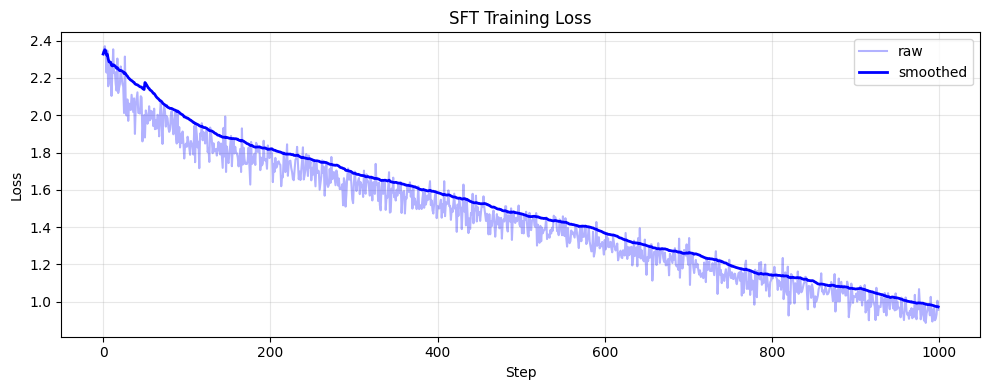

In [13]:
# Plot SFT training loss
plt.figure(figsize=(10, 4))
plt.plot(sft_losses, alpha=0.3, color='blue', label='raw')
# Smoothed
window = 50
if len(sft_losses) > window:
    smoothed = [sum(sft_losses[max(0,i-window):i+1])/min(i+1, window) for i in range(len(sft_losses))]
    plt.plot(smoothed, color='blue', linewidth=2, label='smoothed')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('SFT Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 5: Before vs. After

Now let's see if the model learned the chat format. We'll prompt it with `<|user|>...<|end|><|assistant|>` and see if it generates a response instead of random autocomplete.

In [14]:
def chat(model, user_msg, max_tokens=60):
    """Send a message to the SFT model and get a response."""
    prompt = f"<|user|>{user_msg}<|end|><|assistant|>"
    tokens = encode_sft(prompt)
    idx = torch.tensor([tokens], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        output = model.generate(idx, max_new_tokens=max_tokens)[0].tolist()
    model.train()

    # Decode and extract just the assistant's response
    full_text = decode_sft(output)
    # Find the response after <|assistant|>
    if '<|assistant|>' in full_text:
        response = full_text.split('<|assistant|>')[-1]
        # Stop at <|end|> if present
        if '<|end|>' in response:
            response = response.split('<|end|>')[0]
        return response.strip()
    return full_text

def autocomplete(model, text, max_tokens=60):
    """Use the base model as autocomplete (no chat format)."""
    tokens = encode(text)
    idx = torch.tensor([tokens], dtype=torch.long, device=device)
    model.eval()
    with torch.no_grad():
        output = model.generate(idx, max_new_tokens=max_tokens)[0].tolist()
    model.train()
    return decode(output)

In [15]:
# Compare base model vs SFT model on the same prompts
test_prompts = [
    "Write a greeting",
    "Speak of love",
    "Who are you",
    "I am sad",
    "Give advice",       # seen during training
    "Tell a joke",       # NOT seen during training — can it generalize?
    "Describe the moon", # NOT seen — can it follow the format?
]

print("=" * 70)
print("BASE MODEL (autocomplete)  vs  SFT MODEL (instruction-following)")
print("=" * 70)

for prompt in test_prompts:
    print(f"\nUser: {prompt}")
    print(f"  Base:  {autocomplete(model, prompt, max_tokens=40)[:80]}...")
    print(f"  SFT:   {chat(sft_model, prompt, max_tokens=40)}")
    print("-" * 70)

BASE MODEL (autocomplete)  vs  SFT MODEL (instruction-following)

User: Write a greeting
  Base:  Write a greeting hard,
iled so thealigin cheaing vompeng...
  SFT:   e wisdom wsl gowd, and nothe friend heal
----------------------------------------------------------------------

User: Speak of love
  Base:  Speak of love asen low,
Forseett well ase, theand the...
  SFT:   enod is mor sthe sos in smin tis withe m
----------------------------------------------------------------------

User: Who are you
  Base:  Who are you inger hith,
I howrn ind, he way goids d...
  SFT:   e, fit with the more wabloom the sning w
----------------------------------------------------------------------

User: I am sad
  Base:  I am sadun wor of her thet quy.
LORLIO: penot he...
  SFT:   od poom the wist!
----------------------------------------------------------------------

User: Give advice
  Base:  Give advices me yous uld thoun benieh ute.

A VIDBR...
  SFT:   e and wise allow with mang of in wa gort
-

## Part 6: Catastrophic Forgetting

An important side effect of SFT: the model may **forget** some of what it learned during pre-training. This is called **catastrophic forgetting**.

Let's check: can the SFT model still generate Shakespeare-like text when prompted *without* the chat template?

In [16]:
# Test catastrophic forgetting: generate Shakespeare without chat template
context = torch.zeros((1, 1), dtype=torch.long, device=device)

print("=== Base model (free generation) ===")
model.eval()
with torch.no_grad():
    base_output = model.generate(context, max_new_tokens=200)[0].tolist()
print(decode(base_output))

print("\n=== SFT model (free generation — same prompt) ===")
sft_model.eval()
with torch.no_grad():
    sft_output = sft_model.generate(context, max_new_tokens=200)[0].tolist()
print(decode_sft(sft_output))

print("\n^ Notice any differences? The SFT model may produce less coherent Shakespeare")
print("  because fine-tuning shifted its weights toward the chat format.")
print("  This is catastrophic forgetting in action.")
print("  In practice, teams mitigate this with:")
print("  - Lower learning rate during SFT")
print("  - Mixing in some pre-training data during SFT")
print("  - LoRA (only fine-tune a small set of adapter weights)")

=== Base model (free generation) ===

Whif pord panad the of the you Ge lot;
Whe that his I ifort mady the ther she cos
An hens inart me is you looutinng thin sine wers,
Ton the the sinee: trom no, no a wat to
do my so by lakeave to then 

=== SFT model (free generation — same prompt) ===

nk <|user|>filch rossuartt winds you pon the the the the wathe ater.<|end|><|end|><|end|>not not weltthere theBe the bee usese,, for of domen, widll iss nind bress forres mon kinsull.<|end|>
Coveve heersse depef thear cam wold, the

^ Notice any differences? The SFT model may produce less coherent Shakespeare
  because fine-tuning shifted its weights toward the chat format.
  This is catastrophic forgetting in action.
  In practice, teams mitigate this with:
  - Lower learning rate during SFT
  - Mixing in some pre-training data during SFT
  - LoRA (only fine-tune a small set of adapter weights)


In [17]:
# Let's also measure the loss on validation Shakespeare data
# to quantify how much the model forgot

@torch.no_grad()
def measure_shakespeare_loss(m, vocab_sz):
    """Measure loss on Shakespeare validation data."""
    m.eval()
    losses = []
    for _ in range(100):
        ix = torch.randint(len(val_data) - block_size, (16,))
        x = torch.stack([val_data[i:i+block_size] for i in ix]).to(device)
        y = torch.stack([val_data[i+1:i+block_size+1] for i in ix]).to(device)
        logits, _ = m(x)
        B, T, C = logits.shape
        # Only look at the original vocab (first 65 tokens) for fair comparison
        loss = F.cross_entropy(logits.view(B*T, C)[:, :base_vocab_size],
                               y.view(B*T))
        losses.append(loss.item())
    m.train()
    return sum(losses) / len(losses)

base_val_loss = measure_shakespeare_loss(model, base_vocab_size)
sft_val_loss = measure_shakespeare_loss(sft_model, sft_vocab_size)

print(f"Shakespeare validation loss:")
print(f"  Base model: {base_val_loss:.4f}")
print(f"  SFT model:  {sft_val_loss:.4f}")
print(f"  Difference: {sft_val_loss - base_val_loss:+.4f}")
if sft_val_loss > base_val_loss:
    print(f"\n  The SFT model is worse at Shakespeare — it traded some language")
    print(f"  modeling ability for instruction-following ability.")

Shakespeare validation loss:
  Base model: 2.1263
  SFT model:  2.9142
  Difference: +0.7879

  The SFT model is worse at Shakespeare — it traded some language
  modeling ability for instruction-following ability.


## Key Takeaways

**What SFT does:**
- Takes a base model (autocomplete) and teaches it a new behavior (instruction-following)
- Uses special tokens to define the conversation format
- Loss masking ensures the model only learns from its own responses

**What SFT does NOT do:**
- It doesn't teach the model what a *good* response is vs. a *bad* one
- It just teaches the format: "when you see `<|assistant|>`, generate a response"
- All training examples are treated equally — the model can't learn preferences

**This is the gap that RLHF and DPO fill.** SFT teaches *format*, but preference learning teaches *quality*. That's notebook 06 and 07.

---

### The real-world SFT pipeline

What we built here is the core idea. At scale:
- Models use subword tokenizers (BPE) instead of characters
- SFT datasets have 10K-100K+ examples (we used 40)
- LoRA fine-tunes only ~1% of parameters to reduce forgetting
- Chat templates vary by model family (Llama uses `[INST]`, ChatGPT uses `<|im_start|>`)
- Data quality matters more than quantity — a few thousand expert examples beats millions of noisy ones